# Importo Librerías

In [1]:
# Para visualización en notebook
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
sns.set_context('poster')
mpl.rcParams['figure.figsize'] = (8,6)
import os
import re


# Números y Datos
import numpy as np
import pandas as pd
import copy
import random


# Para manipulación, análisis y visualización de grafos
import networkx as nx
from community import community_louvain

from sklearn.metrics import adjusted_rand_score
from itertools import combinations

from glob import glob
from pathlib import Path
from functools import reduce

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Cargo los datos

In [3]:
# Datos de sujetos
!wget -q https://www.dropbox.com/s/eei6gnw10o20mcn/DataSujetos.zip?dl=1 -O DataSujetos.zip

# Descomprimo archivo
!unzip -q DataSujetos

# Datos de coordenadas
!wget -O aal_extended_withCoords.csv https://www.dropbox.com/scl/fi/pu1qdch4c3khk0uol9l0w/aal_extended_withCoords.csv?rlkey=bsnfot3b9ycp7slble59e1cws&dl=1

--2023-12-09 15:23:44--  https://www.dropbox.com/scl/fi/pu1qdch4c3khk0uol9l0w/aal_extended_withCoords.csv?rlkey=bsnfot3b9ycp7slble59e1cws
Resolving www.dropbox.com (www.dropbox.com)... 162.125.80.18, 2620:100:601d:18::a27d:512
Connecting to www.dropbox.com (www.dropbox.com)|162.125.80.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://uc922564ccc4be2f9a85a750d939.dl.dropboxusercontent.com/cd/0/inline/CJElmjIx28p5Rf9W_xyIgmrr3Dm-0VIMguhED9QZo27F-DmRQ_GTz152YCTXG9wTvqrkJxi21Lay-PFdPXgsKSZXaLqGQ3ic5O3wgmaCrdBtRHpXBw9FcUlTecdHBNvTdMokQuvDtTrLCcCWUyt_WIog/file# [following]
--2023-12-09 15:23:46--  https://uc922564ccc4be2f9a85a750d939.dl.dropboxusercontent.com/cd/0/inline/CJElmjIx28p5Rf9W_xyIgmrr3Dm-0VIMguhED9QZo27F-DmRQ_GTz152YCTXG9wTvqrkJxi21Lay-PFdPXgsKSZXaLqGQ3ic5O3wgmaCrdBtRHpXBw9FcUlTecdHBNvTdMokQuvDtTrLCcCWUyt_WIog/file
Resolving uc922564ccc4be2f9a85a750d939.dl.dropboxusercontent.com (uc922564ccc4be2f9a85a750d939.dl.dropboxusercontent.com)... 162

In [4]:
archivos = os.listdir('DataSujetos/')
regiones = pd.read_csv("aal_extended_withCoords.csv", header=None).iloc[:,1:]

# Consigna

Para identificar diferencias significativas globales en las particiones de comunidades encontradas
entre los distintos estadíos del sueño (N1, N2 y N3), con el estadio despierto
(W) se propone seguir el procedimiento propuesto por Alexander-Bloch y colaboradores
[Alexander-Bloch et al., 2012]. Se quiere saber si las comunidades encontradas en un estadio
de sueño NX y las encontradas en el cerebro despierto W son similares. Para cada estadío
NX realizar el siguiente análisis para todo el rango de valores de $\delta$:

## Cargo Matrices de Adyacencias:

In [5]:
# Cargo las matrices de adyacencia para cada estadío y sujeto
W = {}
# read all W_*.csv in DataSujetos
for f in Path("./DataSujetos").glob("W_*.csv"):
  W[f.stem] = np.loadtxt(f, delimiter=",")
  n = W[f.stem].shape[0]
  W[f.stem] -= np.diag(np.ones(n))
# quitar el prefijo W_suj
# cambiar key a int
W = {int(k.replace('W_suj','')):v for k,v in W.items()}

N1 = {}
# read all N1_*.csv in DataSujetos
for f in Path("./DataSujetos").glob("N1_*.csv"):
  N1[f.stem] = np.loadtxt(f, delimiter=",")
  n = N1[f.stem].shape[0]
  N1[f.stem] -= np.diag(np.ones(n))
# quitar el prefijo N1_suj
# cambiar key a int
N1 = {int(k.replace('N1_suj','')):v for k,v in N1.items()}

N2 = {}
# read all N2_*.csv in DataSujetos
for f in Path("./DataSujetos").glob("N2_*.csv"):
  N2[f.stem] = np.loadtxt(f, delimiter=",")
  n = N2[f.stem].shape[0]
  N2[f.stem] -= np.diag(np.ones(n))
# quitar el prefijo N2_suj
# cambiar key a int
N2 = {int(k.replace('N2_suj','')):v for k,v in N2.items()}

N3 = {}
# read all N3_*.csv in DataSujetos
for f in Path("./DataSujetos").glob("N3_*.csv"):
  N3[f.stem] = np.loadtxt(f, delimiter=",")
  n = N3[f.stem].shape[0]
  N3[f.stem] -= np.diag(np.ones(n))
# quitar el prefijo N3_suj
# cambiar key a int
N3 = {int(k.replace('N3_suj','')):v for k,v in N3.items()}

sujetos_estadios = {'N1':N1, 'N2':N2,'N3':N3,'W':W}

### Funciones útiles:

In [6]:
# Funciones útiles:
def matrizAdyacenciaBinaria(matAdyacPesada, densidad):
    # genera la matriz de adyacencia binaria para una densidad dada
    umbral = density_to_th(matAdyacPesada, densidad)
    matAdyacBinaria = matAdyacPesada >= umbral
    return nx.from_numpy_array(matAdyacBinaria)

def density_to_th(matAdyPesada, densidad):
    # calcula el umbral para producir una densidad determinada
    n = matAdyPesada.shape[0]
    max_links = (n * (n - 1)) // 2
    tril_idx = np.tril_indices(n, -1)
    c = sorted(np.array(list(matAdyPesada[tril_idx].reshape(-1))), reverse=True)
    return c[int((len(c) - 1) * densidad)]

# Función para calcular el índice de Rand ajustado para todos los pares de sujetos en una etapa
def calcular_rand_score_entre_pares(particiones):
    pares_sujetos = list(combinations(particiones.keys(), 2))

    resultados_rand = {}

    for par in pares_sujetos:
        sujeto1, sujeto2 = par

        particiones_sujeto1 = [v for n,v in particiones[sujeto1].items()]
        particiones_sujeto2 = [v for n,v in particiones[sujeto2].items()]
        score = adjusted_rand_score(particiones_sujeto1,particiones_sujeto2)
        resultados_rand[par] = score

    return resultados_rand

def calcular_promedio(resultados):
    scores = resultados.values()
    promedio = sum(scores) / len(scores)
    return promedio

def calcular_desviacion_estandar(resultados):
    scores = resultados.values()
    n = len(scores)
    media = sum(scores) / n
    suma_cuadrados = sum((x - media) ** 2 for x in scores)
    desviacion_estandar = (suma_cuadrados / n) ** 0.5
    return desviacion_estandar

def calcular_desviacion_estandar(resultados):
    scores = np.array(list(resultados.values()))
    desviacion_estandar = np.std(scores)
    return desviacion_estandar

def promedio_rio(promedio_Nx, promedio_W):
  promedio = (promedio_Nx+promedio_W)/2
  return promedio

## W vs Nx:

In [7]:
densidades = np.linspace(0.0, 0.15, 30)

# Diccionarios para almacenar resultados por densidad
resultados_por_densidad = {'rio_1': {'densidad': [],'promedio': [], 'desviacion_estandar': []},
                           'rio_2': {'densidad': [],'promedio': [], 'desviacion_estandar': []},
                           'rio_3': {'densidad': [],'promedio': [], 'desviacion_estandar': []}}

for densidad in densidades:
  resultados_por_densidad['rio_1']['densidad'].append(densidad)
  resultados_por_densidad['rio_2']['densidad'].append(densidad)
  resultados_por_densidad['rio_3']['densidad'].append(densidad)

  # Diccionario para almacenar los grafos por estadio y sujeto en la densidad actual
  grafos = {}

  # Iterar sobre cada estadio del sueño
  for estadio, matrices_sujetos in sujetos_estadios.items():
      # Iterar sobre cada sujeto
      for sujeto, matriz_adyacencia in matrices_sujetos.items():
          # Almacenar los grafos para la densidad actual
          grafo = matrizAdyacenciaBinaria(matriz_adyacencia, densidad)
          nombre_clave = f"{estadio}_{sujeto}"
          grafos[nombre_clave] = grafo


  # Diccionarios para almacenar los resultados de Louvain
  louvain_N1 = {}
  louvain_N2 = {}
  louvain_N3 = {}
  louvain_W = {}

  # Calcular Louvain para cada grafo y almacenar los resultados
  for key, grafo in grafos.items():
      particion = community_louvain.best_partition(grafo)

      if key.startswith('N1_'):
          louvain_N1[key] = particion
      elif key.startswith('N2_'):
          louvain_N2[key] = particion
      elif key.startswith('N3_'):
          louvain_N3[key] = particion
      elif key.startswith('W_'):
          louvain_W[key] = particion

  # Calcular el índice de Rand ajustado para los pares de particiones encontradas
  resultados_N1 = calcular_rand_score_entre_pares(louvain_N1)
  resultados_N2 = calcular_rand_score_entre_pares(louvain_N2)
  resultados_N3 = calcular_rand_score_entre_pares(louvain_N3)
  resultados_W = calcular_rand_score_entre_pares(louvain_W)

  # Calcular el promedio de los rand encontrados para cada estadio
  promedio_N1 = calcular_promedio(resultados_N1)
  promedio_N2 = calcular_promedio(resultados_N2)
  promedio_N3 = calcular_promedio(resultados_N3)
  promedio_W = calcular_promedio(resultados_W)

  # Calculo el promedio del promedio (es decir, RIo)
  rio_1, rio_2, rio_3 = promedio_rio(promedio_N1, promedio_W), promedio_rio(promedio_N2, promedio_W), promedio_rio(promedio_N3, promedio_W)

  # Almacena los resultados para cada densidad
  resultados_por_densidad['rio_1']['promedio'].append(rio_1)
  resultados_por_densidad['rio_2']['promedio'].append(rio_2)
  resultados_por_densidad['rio_3']['promedio'].append(rio_3)

  # Calcula y almacena las desviaciones estándar para cada Río
  desviacion_N1 = calcular_desviacion_estandar(resultados_N1)
  desviacion_N2 = calcular_desviacion_estandar(resultados_N2)
  desviacion_N3 = calcular_desviacion_estandar(resultados_N3)
  desviacion_W = calcular_desviacion_estandar(resultados_W)

  resultados_por_densidad['rio_1']['desviacion_estandar'].append(desviacion_N1)
  resultados_por_densidad['rio_2']['desviacion_estandar'].append(desviacion_N2)
  resultados_por_densidad['rio_3']['desviacion_estandar'].append(desviacion_N3)

In [8]:
df_rio_1 = pd.DataFrame({
    'Densidad': resultados_por_densidad['rio_1']['densidad'],
    'Promedio': resultados_por_densidad['rio_1']['promedio'],
    'Desviacion_Estandar': resultados_por_densidad['rio_1']['desviacion_estandar']
})

df_rio_2 = pd.DataFrame({
    'Densidad': resultados_por_densidad['rio_2']['densidad'],
    'Promedio': resultados_por_densidad['rio_2']['promedio'],
    'Desviacion_Estandar': resultados_por_densidad['rio_2']['desviacion_estandar']
})

df_rio_3 = pd.DataFrame({
    'Densidad': resultados_por_densidad['rio_3']['densidad'],
    'Promedio': resultados_por_densidad['rio_3']['promedio'],
    'Desviacion_Estandar': resultados_por_densidad['rio_3']['desviacion_estandar']
})

## Gráficos W vs Nx:

In [9]:
df_rio_1 = df_rio_1.drop(0)
df_rio_2 = df_rio_2.drop(0)
df_rio_3 = df_rio_3.drop(0)

/usr/local/lib/python3.10/dist-packages/matplotlib/axes/_axes.py:1185: RuntimeWarning: All-NaN axis encountered
  miny = np.nanmin(masked_verts[..., 1])
/usr/local/lib/python3.10/dist-packages/matplotlib/axes/_axes.py:1186: RuntimeWarning: All-NaN axis encountered
  maxy = np.nanmax(masked_verts[..., 1])
/usr/local/lib/python3.10/dist-packages/matplotlib/axes/_axes.py:1185: RuntimeWarning: All-NaN axis encountered
  miny = np.nanmin(masked_verts[..., 1])
/usr/local/lib/python3.10/dist-packages/matplotlib/axes/_axes.py:1186: RuntimeWarning: All-NaN axis encountered
  maxy = np.nanmax(masked_verts[..., 1])
/usr/local/lib/python3.10/dist-packages/matplotlib/axes/_axes.py:1185: RuntimeWarning: All-NaN axis encountered
  miny = np.nanmin(masked_verts[..., 1])
/usr/local/lib/python3.10/dist-packages/matplotlib/axes/_axes.py:1186: RuntimeWarning: All-NaN axis encountered
  maxy = np.nanmax(masked_verts[..., 1])


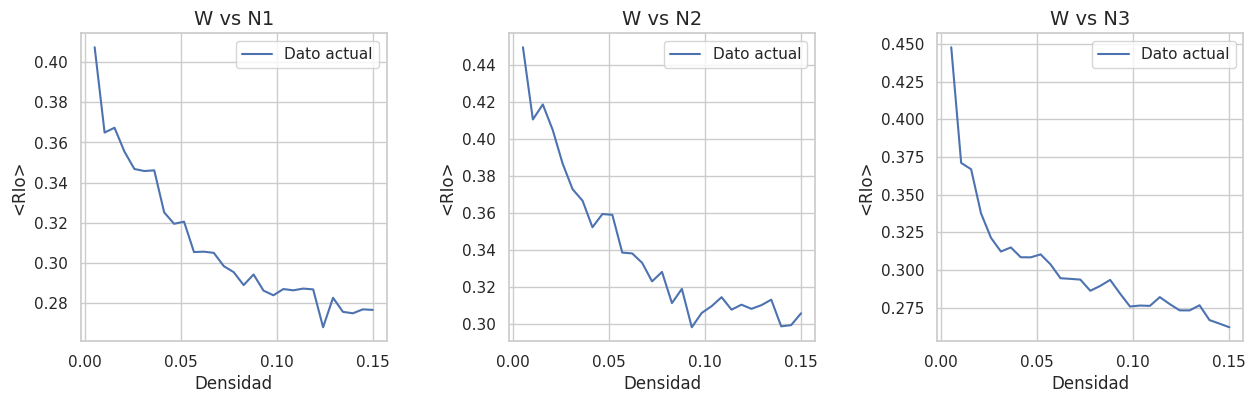

In [10]:
# Configurar el tamaño global de la figura
plt.figure(figsize=(15, 4))  # Cambia el tamaño según sea necesario

# Configurar el estilo de Seaborn (puedes ajustar según tus preferencias)
sns.set(style="whitegrid")

# Crear una grilla de 1x3 para tus tres gráficos
grid = plt.GridSpec(1, 3, width_ratios=[4, 4, 4], wspace=0.4)


# Gráfico para rio_1
plt.subplot(grid[0])
sns.lineplot(data=df_rio_1, x='Densidad', y='Promedio', label='Dato actual',err_style="bars",errorbar=("ci", 2))
plt.title('W vs N1', fontsize=14)  # Ajusta el tamaño de la fuente del título
plt.ylabel('<RIo>')

# Gráfico para rio_2
plt.subplot(grid[1])
sns.lineplot(data=df_rio_2, x='Densidad', y='Promedio', label='Dato actual',err_style="bars",errorbar=("ci", 2))
plt.title('W vs N2', fontsize=14)  # Ajusta el tamaño de la fuente del título
plt.ylabel('<RIo>')

# Gráfico para rio_3
plt.subplot(grid[2])
sns.lineplot(data=df_rio_3, x='Densidad', y='Promedio', label='Dato actual',err_style="bars", errorbar=("ci", 2))
plt.title('W vs N3', fontsize=14)  # Ajusta el tamaño de la fuente del título
plt.ylabel('<RIo>')

# Ajustes adicionales (puedes personalizar según tus preferencias)
plt.show()

### Permutaciones:

In [11]:
# Realizo una modificación en los diccionarios con los datos por cada estadio:
# Primero ordeno los sujetos en cada estadio
N1 = dict(sorted(N1.items()))
N2 = dict(sorted(N2.items()))
N3 = dict(sorted(N3.items()))
W = dict(sorted(W.items()))

# Crear un nuevo diccionario con claves modificadas
N1_new = {'N1_' + str(k): v for k, v in N1.items()}
N2_new = {'N2_' + str(k): v for k, v in N2.items()}
N3_new = {'N3_' + str(k): v for k, v in N3.items()}
W_new = {'W_' + str(k): v for k, v in W.items()}

In [12]:
# # Obtener listas de matrices
# matrices_N_1 = list(N1_new.values())
# matrices_W = list(W_new.values())

In [13]:
# def matrix_permutations(matrix_1, matrix_2,p):
#   permuted_group1 = []
#   permuted_group2 = []
#   for i in range(0, len(matrix_1)-1):
#           # Decide con una probabilidad del 50% si se intercambian
#           if np.random.rand() > p:
#               permuted_group1.append(matrix_2[i])
#               permuted_group2.append(matrix_1[i])
#           else:
#               permuted_group1.append(matrix_1[i])
#               permuted_group2.append(matrix_2[i])
#   return permuted_group1, permuted_group2

In [14]:
# matrices_N_1_p,matrices_W_p = matrix_permutations(matrices_N_1, matrices_W,0.5)

In [15]:
# 1. Permutación
def permutacion_intrasujeto(N,W,i):
  # Obtén los números de sujetos
  sujetos = [key.split('_')[1] for key in N.keys()]

  # Inicializa los diccionarios permutados
  N_p= {}
  W_p = {}

  # Alterna entre N1_dict y W_dict para cada sujeto
  for sujeto in sujetos:
      clave_N = f'N{i}_{sujeto}'
      clave_W = f'W_{sujeto}'

      if random.choice([True, False]):
          W_p[clave_N] = N[clave_N]
          N_p[clave_W] = W[clave_W]
      else:
          W_p[clave_W] = W[clave_W]
          N_p[clave_N] = N[clave_N]
  return N_p, W_p

In [16]:
# 2. Iteración por densidad
def iteracion_por_densidades(N_p, W_p, i):
  densidades = np.linspace(0.0, 0.15, 30)

  # Diccionarios para almacenar resultados por densidad
  resultados_por_densidad = {f'rip_{i}': {'densidad': [],'promedio': [], 'desviacion_estandar': []}}

  for densidad in densidades:
    resultados_por_densidad[f'rip_{i}']['densidad'].append(densidad)

    sujetos_estadios_N_W = {'N_p':N_p, 'W_p':W_p}

    # Diccionario para almacenar los grafos por estadio y sujeto en la densidad actual
    grafos = {}
    # Iterar sobre cada estadio del sueño
    for estadio, matrices_sujetos in sujetos_estadios_N_W.items():
        # Iterar sobre cada sujeto
        for sujeto, matriz_adyacencia in matrices_sujetos.items():
            # Almacenar los grafos para la densidad actual
            grafo = matrizAdyacenciaBinaria(matriz_adyacencia, densidad)
            nombre_clave = f"{estadio}_{sujeto}"
            grafos[nombre_clave] = grafo

    # Diccionarios para almacenar los resultados de Louvain
    louvain_N = {}
    louvain_W = {}

    # Calcular Louvain para cada grafo y almacenar los resultados
    for key, grafo in grafos.items():
        particion = community_louvain.best_partition(grafo)

        if key.startswith('N_p'):
            louvain_N[key] = particion
        elif key.startswith('W_p'):
            louvain_W[key] = particion

    # Calcular el índice de Rand ajustado para los pares de particiones encontradas
    resultados_N = calcular_rand_score_entre_pares(louvain_N)
    resultados_W = calcular_rand_score_entre_pares(louvain_W)

    # Calcular el promedio de los rand encontrados para cada estadio
    promedio_N = calcular_promedio(resultados_N)
    promedio_W = calcular_promedio(resultados_W)

    # Calculo el promedio del promedio (es decir, RIo)
    rip = promedio_rio(promedio_N, promedio_W)

    # Almacena los resultados para cada densidad
    resultados_por_densidad[f'rip_{i}']['promedio'].append(rip)


    # Calcula y almacena las desviaciones estándar para cada RI obs
    desviacion_N = calcular_desviacion_estandar(resultados_N)

    resultados_por_densidad[f'rip_{i}']['desviacion_estandar'].append(desviacion_N)

  df_rip = pd.DataFrame({
    'Densidad': resultados_por_densidad[f'rip_{i}']['densidad'],
    'Promedio': resultados_por_densidad[f'rip_{i}']['promedio'],
    'Desviacion_Estandar': resultados_por_densidad[f'rip_{i}']['desviacion_estandar']})

  return df_rip


### W vs N1 random:

In [17]:
N1_p, W_p = permutacion_intrasujeto(N1_new,W_new,1)
df_rip_1 = iteracion_por_densidades(N1_p, W_p, 1)

### W vs N2 random:

In [18]:
N2_p, W_p = permutacion_intrasujeto(N2_new,W_new,2)
df_rip_2 = iteracion_por_densidades(N2_p, W_p, 2)

### W vs N3 random:

In [19]:
N3_p, W_p = permutacion_intrasujeto(N3_new,W_new,3)
df_rip_3 = iteracion_por_densidades(N3_p, W_p, 3)

### Verifico que al permutar se permute correctamente la matriz:

In [20]:
print(N3_p.keys())
print(W_p.keys())

dict_keys(['W_1', 'N3_2', 'N3_3', 'W_4', 'N3_5', 'W_6', 'N3_7', 'N3_8', 'W_9', 'W_10', 'N3_11', 'N3_12', 'N3_13', 'N3_14', 'W_15', 'N3_16', 'W_17', 'W_18'])
dict_keys(['N3_1', 'W_2', 'W_3', 'N3_4', 'W_5', 'N3_6', 'W_7', 'W_8', 'N3_9', 'N3_10', 'W_11', 'W_12', 'W_13', 'W_14', 'N3_15', 'W_16', 'N3_17', 'N3_18'])


In [22]:
# N3_1_original = N3[1]
# N3_1_p = N3_p['N3_1']

In [23]:
# print(np.array_equal(N3_1_original, N3_1_p))

## Gráficos random W vs Nx:

In [24]:
df_rip_1 = df_rip_1.drop(0)
df_rip_2 = df_rip_2.drop(0)
df_rip_3 = df_rip_3.drop(0)

/usr/local/lib/python3.10/dist-packages/matplotlib/axes/_axes.py:1185: RuntimeWarning: All-NaN axis encountered
  miny = np.nanmin(masked_verts[..., 1])
/usr/local/lib/python3.10/dist-packages/matplotlib/axes/_axes.py:1186: RuntimeWarning: All-NaN axis encountered
  maxy = np.nanmax(masked_verts[..., 1])
/usr/local/lib/python3.10/dist-packages/matplotlib/axes/_axes.py:1185: RuntimeWarning: All-NaN axis encountered
  miny = np.nanmin(masked_verts[..., 1])
/usr/local/lib/python3.10/dist-packages/matplotlib/axes/_axes.py:1186: RuntimeWarning: All-NaN axis encountered
  maxy = np.nanmax(masked_verts[..., 1])
/usr/local/lib/python3.10/dist-packages/matplotlib/axes/_axes.py:1185: RuntimeWarning: All-NaN axis encountered
  miny = np.nanmin(masked_verts[..., 1])
/usr/local/lib/python3.10/dist-packages/matplotlib/axes/_axes.py:1186: RuntimeWarning: All-NaN axis encountered
  maxy = np.nanmax(masked_verts[..., 1])


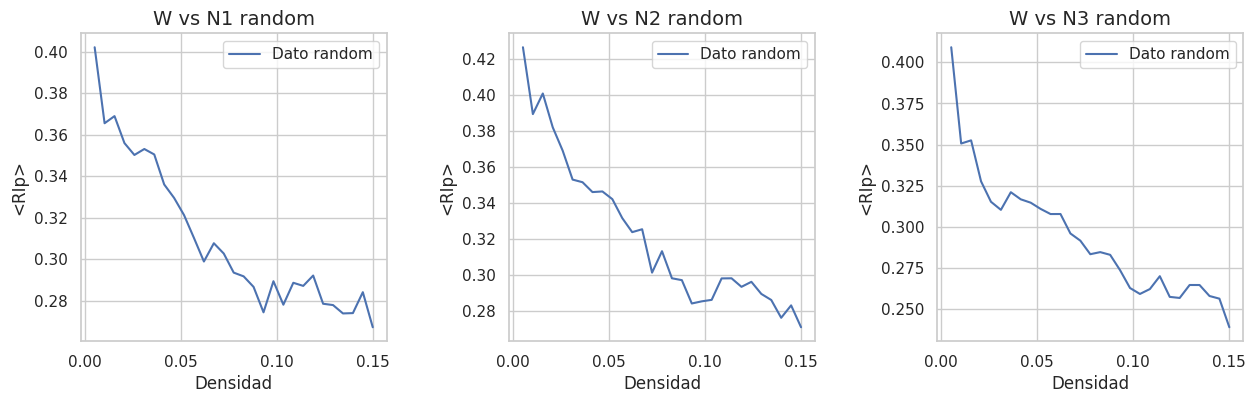

In [25]:
# Configurar el tamaño global de la figura
plt.figure(figsize=(15, 4))  # Cambia el tamaño según sea necesario

# Configurar el estilo de Seaborn (puedes ajustar según tus preferencias)
sns.set(style="whitegrid")

# Crear una grilla de 1x3 para tus tres gráficos
grid = plt.GridSpec(1, 3, width_ratios=[4, 4, 4], wspace=0.4)

# Gráfico para rio_1
plt.subplot(grid[0])
sns.lineplot(data=df_rip_1, x='Densidad', y='Promedio', label='Dato random',err_style="bars",errorbar=("ci", 0.1))
plt.title('W vs N1 random', fontsize=14)
plt.ylabel('<RIp>')

# Gráfico para rio_2
plt.subplot(grid[1])
sns.lineplot(data=df_rip_2, x='Densidad', y='Promedio', label='Dato random',err_style="bars",errorbar=("ci", 0.1))
plt.title('W vs N2 random', fontsize=14)
plt.ylabel('<RIp>')

# Gráfico para rio_3
plt.subplot(grid[2])
sns.lineplot(data=df_rip_3, x='Densidad', y='Promedio', label='Dato random',err_style="bars", errorbar=("ci", 0.1))
plt.title('W vs N3 random', fontsize=14)
plt.ylabel('<RIp>')

# Ajustes adicionales (puedes personalizar según tus preferencias)
plt.show()

### Gráfico conjunto:

/usr/local/lib/python3.10/dist-packages/matplotlib/axes/_axes.py:1185: RuntimeWarning: All-NaN axis encountered
  miny = np.nanmin(masked_verts[..., 1])
/usr/local/lib/python3.10/dist-packages/matplotlib/axes/_axes.py:1186: RuntimeWarning: All-NaN axis encountered
  maxy = np.nanmax(masked_verts[..., 1])
/usr/local/lib/python3.10/dist-packages/matplotlib/axes/_axes.py:1185: RuntimeWarning: All-NaN axis encountered
  miny = np.nanmin(masked_verts[..., 1])
/usr/local/lib/python3.10/dist-packages/matplotlib/axes/_axes.py:1186: RuntimeWarning: All-NaN axis encountered
  maxy = np.nanmax(masked_verts[..., 1])
/usr/local/lib/python3.10/dist-packages/matplotlib/axes/_axes.py:1185: RuntimeWarning: All-NaN axis encountered
  miny = np.nanmin(masked_verts[..., 1])
/usr/local/lib/python3.10/dist-packages/matplotlib/axes/_axes.py:1186: RuntimeWarning: All-NaN axis encountered
  maxy = np.nanmax(masked_verts[..., 1])
/usr/local/lib/python3.10/dist-packages/matplotlib/axes/_axes.py:1185: RuntimeWarn

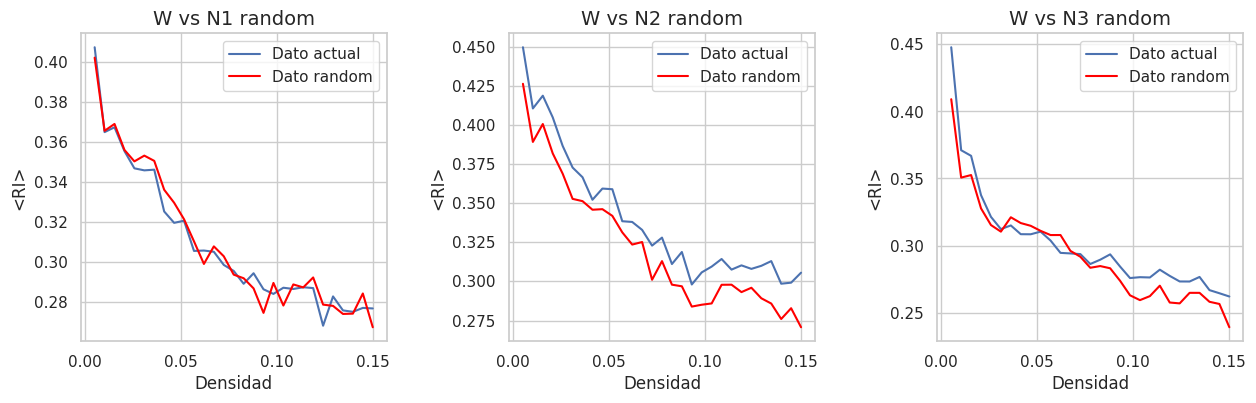

In [26]:
# Configurar el tamaño global de la figura
plt.figure(figsize=(15, 4))  # Cambia el tamaño según sea necesario

# Configurar el estilo de Seaborn (puedes ajustar según tus preferencias)
sns.set(style="whitegrid")

# Crear una grilla de 1x3 para tus tres gráficos
grid = plt.GridSpec(1, 3, width_ratios=[4, 4, 4], wspace=0.4)

# Gráfico para rio_1
plt.subplot(grid[0])
sns.lineplot(data=df_rio_1, x='Densidad', y='Promedio', label='Dato actual', err_style="bars", errorbar=("ci", 0.1))
sns.lineplot(data=df_rip_1, x='Densidad', y='Promedio', label='Dato random', err_style="bars", errorbar=("ci", 0.1), color='red')
plt.title('W vs N1 random', fontsize=14)
plt.ylabel('<RI>')

# Gráfico para rio_2
plt.subplot(grid[1])
sns.lineplot(data=df_rio_2, x='Densidad', y='Promedio', label='Dato actual', err_style="bars", errorbar=("ci", 0.1))
sns.lineplot(data=df_rip_2, x='Densidad', y='Promedio', label='Dato random', err_style="bars", errorbar=("ci", 0.1), color='red')
plt.title('W vs N2 random', fontsize=14)
plt.ylabel('<RI>')

# Gráfico para rio_3
plt.subplot(grid[2])
sns.lineplot(data=df_rio_3, x='Densidad', y='Promedio', label='Dato actual', err_style="bars", errorbar=("ci", 0.1))
sns.lineplot(data=df_rip_3, x='Densidad', y='Promedio', label='Dato random', err_style="bars", errorbar=("ci", 0.1), color='red')
plt.title('W vs N3 random', fontsize=14)
plt.ylabel('<RI>')

# Ajustes adicionales (puedes personalizar según tus preferencias)
plt.show()

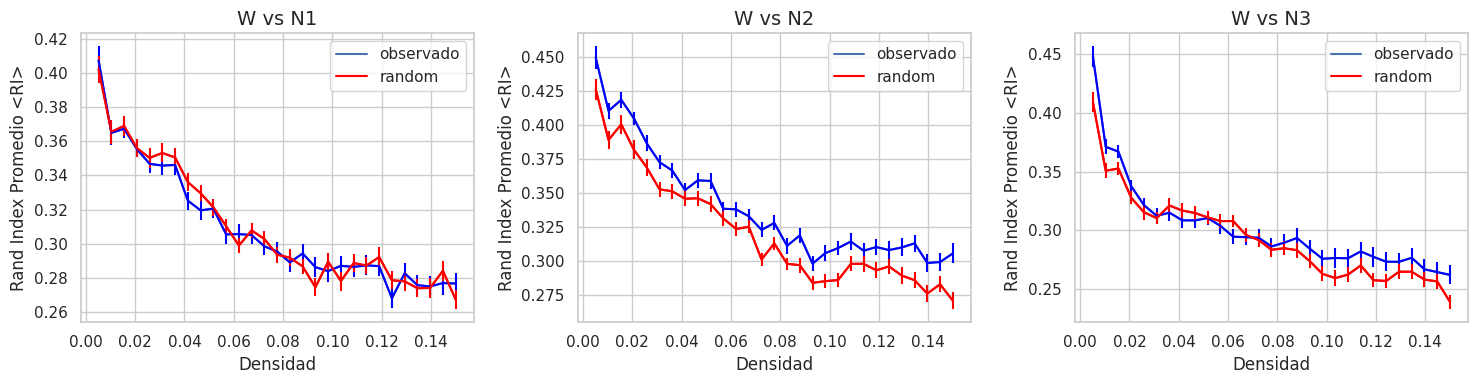

In [27]:
# Configurar el tamaño global de la figura
plt.figure(figsize=(15, 4))  # Cambia el tamaño según sea necesario

# Gráfico para rio_1
plt.subplot(1, 3, 1)
plt.plot(df_rio_1['Densidad'], df_rio_1['Promedio'], label='observado')
plt.errorbar(df_rio_1['Densidad'], df_rio_1['Promedio'], yerr=df_rio_1['Desviacion_Estandar']/18, color='blue')
plt.plot(df_rip_1['Densidad'], df_rip_1['Promedio'], label='random', color='red')
plt.errorbar(df_rip_1['Densidad'], df_rip_1['Promedio'], yerr=df_rip_1['Desviacion_Estandar']/18,  color='red')
plt.title('W vs N1', fontsize=14)
plt.xlabel('Densidad')
plt.ylabel('Rand Index Promedio <RI>')
plt.legend()

# Gráfico para rio_2
plt.subplot(1, 3, 2)
plt.plot(df_rio_2['Densidad'], df_rio_2['Promedio'], label='observado')
plt.errorbar(df_rio_2['Densidad'], df_rio_2['Promedio'], yerr=df_rio_2['Desviacion_Estandar']/18, color='blue')
plt.plot(df_rip_2['Densidad'], df_rip_2['Promedio'], label='random', color='red')
plt.errorbar(df_rip_2['Densidad'], df_rip_2['Promedio'], yerr=df_rip_2['Desviacion_Estandar']/18, color='red')
plt.title('W vs N2', fontsize=14)
plt.xlabel('Densidad')
plt.ylabel('Rand Index Promedio <RI>')
plt.legend()

# Gráfico para rio_3
plt.subplot(1, 3, 3)
plt.plot(df_rio_3['Densidad'], df_rio_3['Promedio'], label='observado')
plt.errorbar(df_rio_3['Densidad'], df_rio_3['Promedio'], yerr=df_rio_3['Desviacion_Estandar']/18, color='blue')
plt.plot(df_rip_3['Densidad'], df_rip_3['Promedio'], label='random', color='red')
plt.errorbar(df_rip_3['Densidad'], df_rip_3['Promedio'], yerr=df_rip_3['Desviacion_Estandar']/18, color='red')
plt.title('W vs N3', fontsize=14)
plt.xlabel('Densidad')
plt.ylabel('Rand Index Promedio <RI>')
plt.legend()

# Ajustes adicionales (puedes personalizar según tus preferencias)
plt.tight_layout()
plt.savefig('/content/drive/MyDrive/DMCYT/img_1')
plt.show()

### N Permutaciones y p_value:

In [27]:
dfs_1 = []
for i in range(100):
  N1_p, W_p = permutacion_intrasujeto(N1_new,W_new,1)
  df_rip_1 = iteracion_por_densidades(N1_p, W_p, 1)
  df_rip_1.rename(columns={'Promedio':f'Promedio_{i}'}, inplace=True)
  dfs_1.append(df_rip_1[['Densidad', f'Promedio_{i}']])

In [28]:
# Realizar el merge iterativo utilizando la función reduce
merged_df1 = reduce(lambda left, right: pd.merge(left, right, on='Densidad'), dfs_1)

# Realizo join con el RIobs
merged_df1_final = merged_df1.merge(df_rio_1[['Densidad', 'Promedio']], how='left', on='Densidad')

# Crear una columna 'cant_veces'
merged_df1_final['cant_veces'] = merged_df1_final.filter(like='Promedio').gt(merged_df1_final['Promedio'], axis=0).sum(axis=1)

# Crear una columna 'p-valor'
merged_df1_final['p-valor'] = merged_df1_final['cant_veces'] / merged_df1_final.filter(like='Promedio').shape[1]

In [29]:
dfs_2 = []
for i in range(100):
  N2_p, W_p = permutacion_intrasujeto(N2_new,W_new,2)
  df_rip_2 = iteracion_por_densidades(N2_p, W_p, 2)
  df_rip_2.rename(columns={'Promedio':f'Promedio_{i}'}, inplace=True)
  dfs_2.append(df_rip_2[['Densidad', f'Promedio_{i}']])

In [30]:
# Realizar el merge iterativo utilizando la función reduce
merged_df2 = reduce(lambda left, right: pd.merge(left, right, on='Densidad'), dfs_2)

# Realizo join con el RIobs
merged_df2_final = merged_df2.merge(df_rio_2[['Densidad', 'Promedio']], how='left', on='Densidad')

# Crear una columna 'cant_veces'
merged_df2_final['cant_veces'] = merged_df2_final.filter(like='Promedio').gt(merged_df2_final['Promedio'], axis=0).sum(axis=1)

# Crear una columna 'p-valor'
merged_df2_final['p-valor'] = merged_df2_final['cant_veces'] / merged_df2_final.filter(like='Promedio').shape[1]

In [31]:
dfs_3 = []
for i in range(100):
  N3_p, W_p = permutacion_intrasujeto(N3_new,W_new,3)
  df_rip_3 = iteracion_por_densidades(N3_p, W_p, 3)
  df_rip_3.rename(columns={'Promedio':f'Promedio_{i}'}, inplace=True)
  dfs_3.append(df_rip_3[['Densidad', f'Promedio_{i}']])

In [32]:
# Realizar el merge iterativo utilizando la función reduce
merged_df3 = reduce(lambda left, right: pd.merge(left, right, on='Densidad'), dfs_3)

# Realizo join con el RIobs
merged_df3_final = merged_df3.merge(df_rio_3[['Densidad', 'Promedio']], how='left', on='Densidad')

# Crear una columna 'cant_veces'
merged_df3_final['cant_veces'] = merged_df3_final.filter(like='Promedio').gt(merged_df3_final['Promedio'], axis=0).sum(axis=1)

# Crear una columna 'p-valor'
merged_df3_final['p-valor'] = merged_df3_final['cant_veces'] / merged_df3_final.filter(like='Promedio').shape[1]

In [33]:
merged_df1_final.to_csv('/content/drive/MyDrive/DMCYT/n1', index=False)
merged_df2_final.to_csv('/content/drive/MyDrive/DMCYT/n2', index=False)
merged_df3_final.to_csv('/content/drive/MyDrive/DMCYT/n3', index=False)

In [28]:
import pandas as pd
df_1 = pd.read_csv('/content/drive/MyDrive/DMCYT/n1')
df_2 = pd.read_csv('/content/drive/MyDrive/DMCYT/n2')
df_3 = pd.read_csv('/content/drive/MyDrive/DMCYT/n3')

In [36]:
df_1

,Densidad,Promedio_0,Promedio_1,Promedio_2,Promedio_3,Promedio_4,Promedio_5,Promedio_6,Promedio_7,Promedio_8,...,Promedio_94,Promedio_95,Promedio_96,Promedio_97,Promedio_98,Promedio_99,Promedio,cant_veces,p-valor,sig
0,0.000000,0.124052,0.120783,0.120783,0.117515,0.120783,0.117515,0.124052,0.127320,0.133857,...,0.117515,0.117515,0.117515,0.120783,0.114246,0.120783,NaN,0,0.000000,0.2
1,0.005172,0.399121,0.403535,0.403609,0.398228,0.400191,0.402334,0.415187,0.401262,0.403125,...,0.402184,0.406706,0.400543,0.400956,0.398707,0.402870,0.403701,41,0.405941,NaN
2,0.010345,0.364523,0.366475,0.362368,0.364392,0.362779,0.366457,0.363602,0.360670,0.361522,...,0.363901,0.359978,0.366216,0.367195,0.365753,0.362619,0.366330,20,0.198020,NaN
3,0.015517,0.362253,0.364807,0.358452,0.359533,0.361554,0.364141,0.357552,0.362968,0.360444,...,0.367340,0.365496,0.357975,0.366970,0.357163,0.364384,0.364538,28,0.277228,NaN
4,0.020690,0.358067,0.347225,0.349130,0.357294,0.354727,0.357126,0.351013,0.351251,0.352713,...,0.359978,0.351202,0.353720,0.354608,0.352892,0.354473,0.347784,92,0.910891,NaN
5,0.025862,0.346232,0.345659,0.339226,0.349933,0.343273,0.355632,0.347238,0.348654,0.349574,...,0.346843,0.350857,0.341417,0.342279,0.350873,0.356401,0.346278,71,0.702970,NaN
6,0.031034,0.343267,0.346457,0.356498,0.352781,0.340680,0.350430,0.350559,0.347406,0.349884,...,0.342739,0.350679,0.347656,0.353461,0.346766,0.348240,0.348724,35,0.346535,NaN
7,0.036207,0.354974,0.362697,0.360197,0.350901,0.359561,0.354050,0.349689,0.353298,0.347119,...,0.351037,0.348430,0.356162,0.345797,0.342149,0.368049,0.355413,26,0.257426,NaN
8,0.041379,0.331835,0.335941,0.334055,0.337619,0.330387,0.331312,0.334790,0.332893,0.329808,...,0.332683,0.336265,0.340726,0.331261,0.330410,0.338767,0.338010,9,0.089109,NaN
9,0.046552,0.310024,0.329513,0.325489,0.323476,0.326719,0.322458,0.330821,0.320371,0.334580,...,0.332534,0.330055,0.320741,0.323347,0.322214,0.324765,0.318970,83,0.821782,NaN


In [32]:
df_1['sig'] = df_1['p-valor'].apply(lambda x: 0.2 if x < 0.05 else None)
df_2['sig'] = df_2['p-valor'].apply(lambda x: 0.2 if x < 0.05 else None)
df_3['sig'] = df_3['p-valor'].apply(lambda x: 0.2 if x < 0.05 else None)

### Gráfico Final

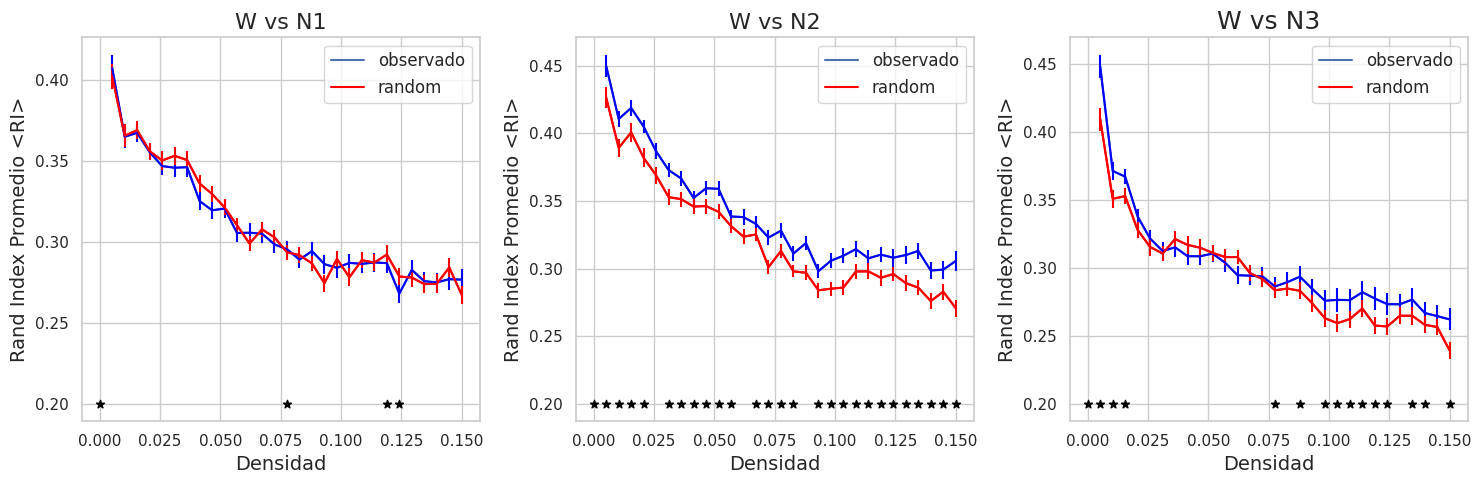

In [42]:
# Configurar el tamaño global de la figura
plt.figure(figsize=(15, 5))  # Cambia el tamaño según sea necesario

# Gráfico para rio_1
plt.subplot(1, 3, 1)
plt.plot(df_rio_1['Densidad'], df_rio_1['Promedio'], label='observado')
plt.errorbar(df_rio_1['Densidad'], df_rio_1['Promedio'], yerr=df_rio_1['Desviacion_Estandar']/18, color='blue')
plt.plot(df_rip_1['Densidad'], df_rip_1['Promedio'], label='random', color='red')
plt.errorbar(df_rip_1['Densidad'], df_rip_1['Promedio'], yerr=df_rip_1['Desviacion_Estandar']/18,  color='red')
plt.scatter(df_1['Densidad'], df_1['sig'], marker='*', color='black')
plt.title('W vs N1', fontsize=16)
plt.xlabel('Densidad', fontsize=14)
plt.ylabel('Rand Index Promedio <RI>', fontsize=14)
plt.legend(fontsize=12)


# Gráfico para rio_2
plt.subplot(1, 3, 2)
plt.plot(df_rio_2['Densidad'], df_rio_2['Promedio'], label='observado')
plt.errorbar(df_rio_2['Densidad'], df_rio_2['Promedio'], yerr=df_rio_2['Desviacion_Estandar']/18, color='blue')
plt.plot(df_rip_2['Densidad'], df_rip_2['Promedio'], label='random', color='red')
plt.errorbar(df_rip_2['Densidad'], df_rip_2['Promedio'], yerr=df_rip_2['Desviacion_Estandar']/18, color='red')
plt.title('W vs N2', fontsize=16)
plt.scatter(df_2['Densidad'], df_2['sig'], marker='*', color='black')
plt.xlabel('Densidad', fontsize=14)
plt.ylabel('Rand Index Promedio <RI>', fontsize=14)
plt.legend(fontsize=12)

# Gráfico para rio_3
plt.subplot(1, 3, 3)
plt.plot(df_rio_3['Densidad'], df_rio_3['Promedio'], label='observado')
plt.errorbar(df_rio_3['Densidad'], df_rio_3['Promedio'], yerr=df_rio_3['Desviacion_Estandar']/18, color='blue')
plt.plot(df_rip_3['Densidad'], df_rip_3['Promedio'], label='random', color='red')
plt.errorbar(df_rip_3['Densidad'], df_rip_3['Promedio'], yerr=df_rip_3['Desviacion_Estandar']/18, color='red')
plt.title('W vs N3', fontsize=18)
plt.scatter(df_3['Densidad'], df_3['sig'], marker='*', color='black')
plt.xlabel('Densidad', fontsize=14)  # Ajusta el tamaño del texto del eje x
plt.ylabel('Rand Index Promedio <RI>', fontsize=14)  # Ajusta el tamaño del texto del eje y
plt.legend(fontsize=12)

# Ajustes adicionales (puedes personalizar según tus preferencias)
plt.tight_layout()
plt.savefig('/content/drive/MyDrive/DMCYT/img_2', dpi=300)
plt.show()